In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator

In [2]:
df_train = pd.read_csv('df_train.csv')
df_test  = pd.read_csv('df_test.csv')

In [3]:
# df_train

## Explonatory Data Analysis

Independent variable (Target) is `SalePrice`

In [4]:
df_train.SalePrice.dtypes

dtype('int64')

1.8828757597682129


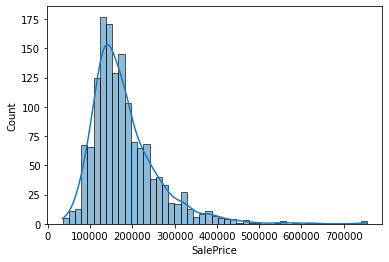

In [5]:
sns.histplot(data=df_train,x="SalePrice", kde=True)
print(df_train.SalePrice.skew())

We will adjust skewness later

In [6]:
numerical_features = list(df_train.select_dtypes('number').columns[:-1])
categorical_features = list(df_train.select_dtypes('object').columns)

print('The number of numerical features is ', len(numerical_features)) 
print('The number of catergorical features is ', len(categorical_features)) 

The number of numerical features is  33
The number of catergorical features is  28


### Numerical data

we separate numerical features whose number of unique values <= 30 

In [7]:
numerical_features_less_30 = list(df_train[numerical_features].nunique()
                              .iloc[df_train[numerical_features].nunique().values<=30].index)
numerical_features_more_30 = [x for x in numerical_features if x not in numerical_features_less_30]

#### Numerical features whose number of unique values is $>30$ 

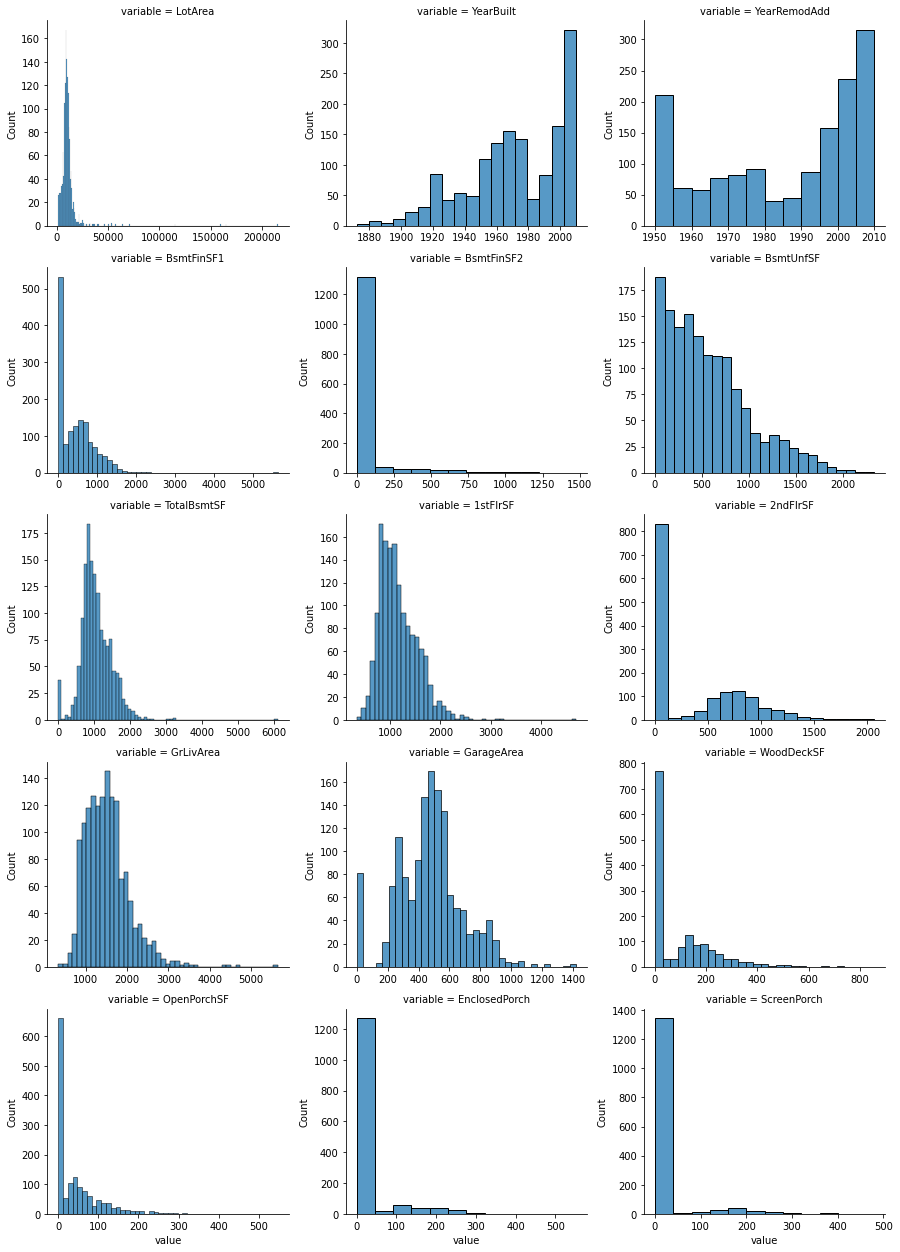

In [8]:
f = pd.melt(df_train[numerical_features_more_30])
fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=1.2)
fg.map(sns.histplot, "value")

In [9]:
numerical_features_more_30 =['LotArea', 'TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea']

In [10]:
adjusted = ['SalePrice']+ numerical_features_more_30 

Adjust skewness

In [11]:
df_train[adjusted].describe().min()

SalePrice      1460.0
LotArea        1300.0
TotalBsmtSF       0.0
1stFlrSF        334.0
GrLivArea       334.0
GarageArea        0.0
dtype: float64

In [12]:
df_train.replace({'TotalBsmtSF':{0:1}, 'GarageArea':{0: 1}}, inplace=True)

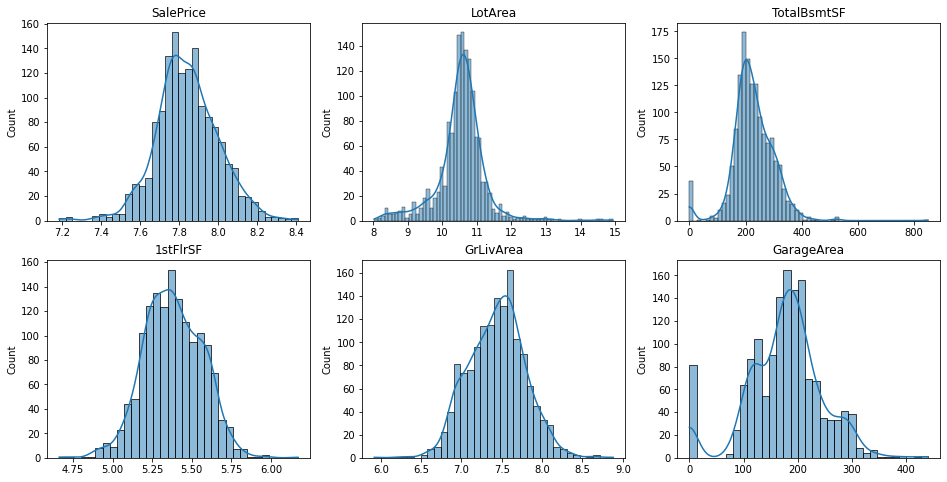

In [13]:
n = len(adjusted)
nrows = (n%3+n)//3

fig, axs = plt.subplots(ncols=3,nrows=nrows,figsize=(16,8))

for k in range(n):
    ftr = adjusted[k]    
    
    i = k // 3
    j = k% 3
    xt, _ = stats.boxcox(df_train[ftr])
    sns.histplot(data=xt, kde=True,ax=axs[i][j])
    axs[i][j].set_title(ftr)
    df_train[ftr] = xt    

### Correlation

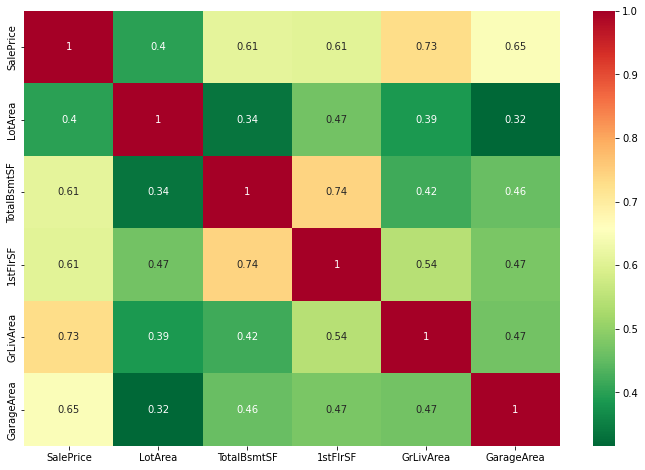

In [14]:
corrmat = df_train[adjusted].corr()
plt.figure(figsize=(12,8))
g = sns.heatmap(corrmat,annot=True,cmap="RdYlGn_r")

We decided to drop `LotArea` are less than 0.5,  these two predictors before fitting the model.

In [15]:
adjusted.remove('LotArea')

In [16]:
adjusted

['SalePrice', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']

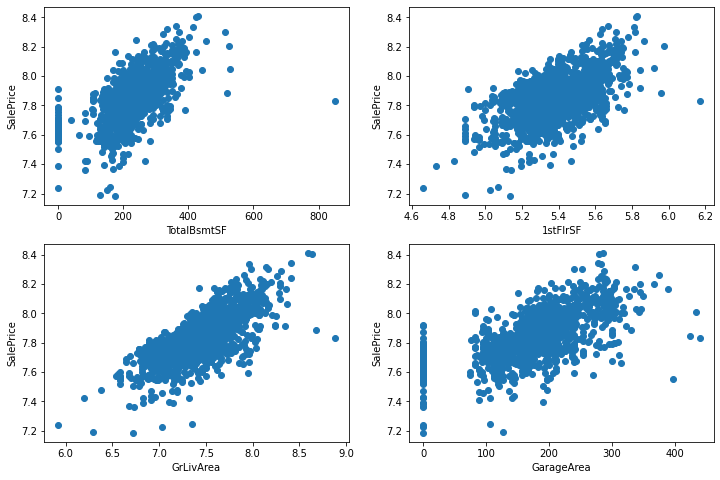

In [17]:
adjusted_features = adjusted.copy()
adjusted_features.remove('SalePrice')

n = len(adjusted_features) 
nrows = (n%2+n)//2


fig, axs = plt.subplots(ncols=2,nrows=nrows,figsize=(12,8))
for k in range(n):
    ftr = adjusted_features[k]    
    
    i = k // 2
    j = k% 2
    
    axs[i,j].scatter(df_train[ftr],df_train.SalePrice)
    axs[i,j].set_xlabel(ftr)
    axs[i,j].set_ylabel('SalePrice')
    # axs[i,j].set_title(ftr)
  

### Categorical

In [18]:
# This function presents all the boxplots of categorical preditors with SalePrice
def srt_box(y, df):
    fig, axes = plt.subplots(16, 3, figsize=(20, 70))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['category']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=True)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

In [19]:
categorical = categorical_features + numerical_features_less_30
df_categorical = df_train[categorical].astype('category',copy=False)
df_categorical['SalePrice'] = df_train['SalePrice']
df_categorical.shape

(1460, 47)

In [ ]:
srt_box('SalePrice', df_categorical)

In [ ]:
# Select potential categorical predictors based on the boxplots above
categorical_features = ['MSZoning', 'Neighborhood','ExterQual','CentralAir','KitchenQual','OverallQual']

In [ ]:
f = pd.melt(df_train[categorical_features])
fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=2.0)
fg.map(sns.histplot, "value")

In [ ]:
categorical_features = ['Neighborhood','ExterQual','KitchenQual','OverallQual']

kept_features = adjusted + categorical_features 

df_train = df_train[kept_features]

In [ ]:
df_train.dtypes

In [ ]:
numerical_features = df_train.select_dtypes('number').columns.values
categorical_features = df_train.select_dtypes('object').columns.values

### One-Hot Encoding in categorical features

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df_train[categorical_features]).toarray())
enc_df

In [ ]:
df_train

### Scaling Numerical Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(df_train.select_dtypes('number'))
df_train[numerical_features] = pd.DataFrame(data,
                        columns=numerical_features,
                        index=df_train.index)
df_train

In [ ]:
df_train = df_train.select_dtypes('number').join(enc_df)
df_train

### Outliers

In [ ]:
# Plotting numerical features with polynomial order to detect outliers.
def srt_reg(y, df):
    fig, axes = plt.subplots(2, 3, figsize=(10,6))
    axes = axes.flatten()

    for i, j in zip(numerical_features, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='chocolate',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

In [ ]:
srt_reg('SalePrice', df_train)

In [ ]:
# Dropping some outliers by identifying them from above
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 5)].index)
df_train = df_train.drop(df_train[(df_train['GarageArea'] > 3)].index)

In [ ]:
srt_reg('SalePrice', df_train)